# Compound Visualization
Here, we demonstrate midnite's compound visualization methods. Read about it in the [docs](https://luminovo.gitlab.io/midnite/visualization.html#specific-visualization-methods).

In [1]:
%%capture
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

## Preparation: Load Pretrained Model and Example Data
As in other notebooks, we use a pretrained Alexnet.

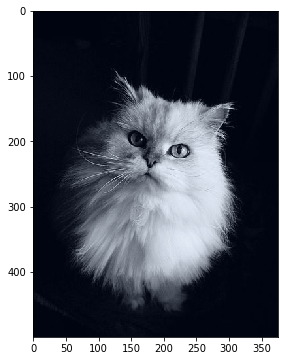

In [2]:
import midnite
import data_utils
from plot_utils import show, show_normalized, show_heatmap
from torchvision import models

net = models.alexnet(pretrained=True)
net.eval().to(midnite.get_device());

example_img = data_utils.get_example_from_path(
    "../data/imagenet_example_283.jpg",
    data_utils.DataConfig.ALEX_NET
)

show_normalized(example_img)

## Preparation: Split Layers
Split network into classifier and feature part - `Flatten` layer is introduct as feature output gets flattened in the Alexnet `forward` method.

In [3]:
from torch.nn import Sequential
from midnite.common import Flatten
from midnite.visualization.compound_methods import *

features = net.features
classifier = Sequential(net.avgpool, Flatten(), net.classifier)

feature_layers = list(features.children())
classifier_layers = list(classifier.children())
layers = feature_layers + classifier_layers

## Methods
### Guided Backpropagation
Highlights which parts of the image are picked up in the gradient.

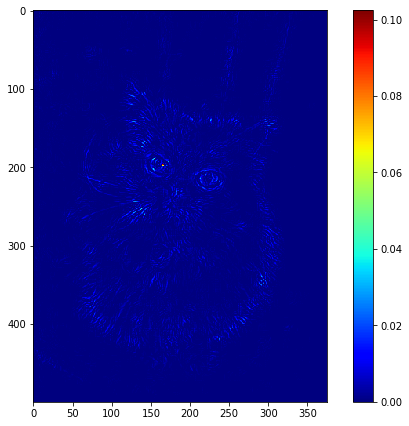

In [4]:
gbp_heatmap = guided_backpropagation(layers, example_img, 1)
show_heatmap(gbp_heatmap, scale=1.2)

### Guided GradCAM
Output similar to guided backpropagation, but weighted on which channels were important for the classification.
Note that while the fur texture was picked up, snout and eyes had much bigger importance for the final classification.

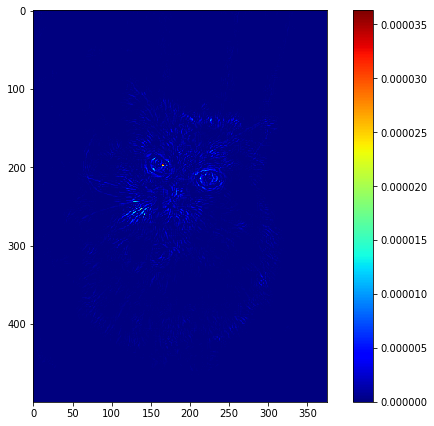

In [5]:
ggc_heatmap = guided_gradcam(feature_layers, classifier_layers, example_img)
show_heatmap(ggc_heatmap, scale=1.2)

### GradCAM
Shows which spatial locations had influence on the most important channels for classification.

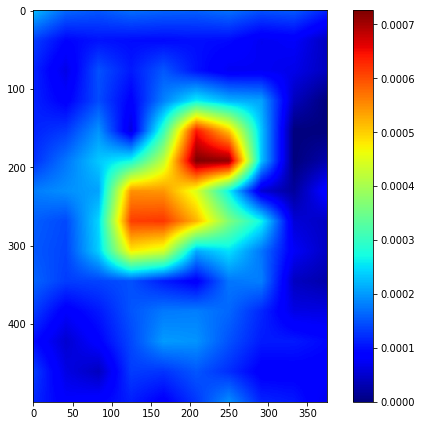

In [6]:
gc_heatmap = gradcam(features, classifier, example_img)
show_heatmap(gc_heatmap, scale=1.2)

### Occlusion
Shows which parts of the image are crucial for correct classification. Requires much more computation time since it's not gradient-based, but should be more robust to noise than other methods. Read more about it in the [Occlusion notebook](https://luminovo.gitlab.io/midnite/notebooks/details_occlusion.html).

100%|██████████| 7500/7500 [00:24<00:00, 312.24it/s]


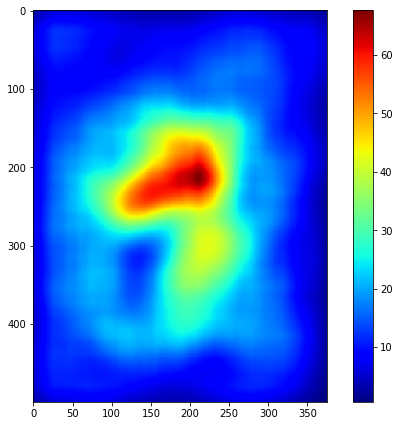

In [7]:
# does not run in short time without GPU
with midnite.device("cuda:0"):
    oc_heatmap = occlusion(net, example_img)

show_heatmap(oc_heatmap, scale=1.2)

### Class Visualization
Generates an image that maximally excites the network for a given class. This is an optimization of the network's gradient in image space and thus requires some computation power.

However, since there is no defined "goal" for visual clarity, it is usually necessary to manually tune the optimization parameters. This can be done by using the [Max Mean Activation](https://luminovo.gitlab.io/midnite/notebooks/details_max_mean_activation.html) building block.

100%|██████████| 50/50 [00:52<00:00,  1.05it/s]


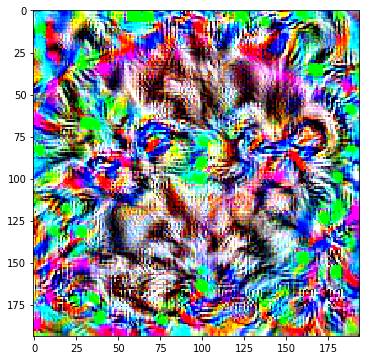

In [8]:
# does not run in short time without GPU
with midnite.device("cuda:0"):
    cv_img = class_visualization(net, 283)

show_normalized(cv_img)

## Experimental
### Gradient Uncertainty Attribution Mapping (GradUAM)
Visualizes where in the image the uncertainty based on mutual information is high. Warning: highly experimental.

100%|██████████| 50/50 [00:00<00:00, 107.31it/s]
Input normally has 3 dimensions. Got: torch.Size([256, 14, 10, 50])
Input should have 1 channel dimensions. Got: torch.Size([256, 14])
Input normally has 3 dimensions. Got: torch.Size([256, 14, 10, 50])


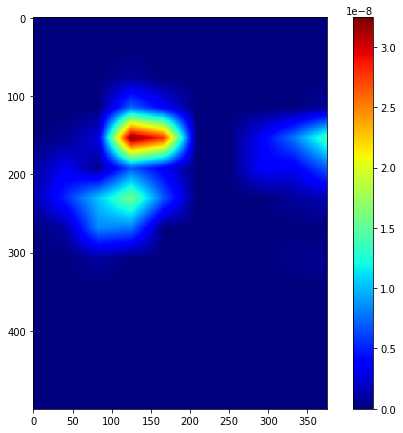

In [9]:
from midnite.uncertainty import StochasticDropouts

gu_heatmap = graduam(StochasticDropouts(features), StochasticDropouts(classifier), example_img)
show_heatmap(gu_heatmap, scale=1.2)